In [11]:
%load_ext autoreload
%autoreload 2

In [17]:
import numpy as np
import yaml
import matplotlib.pyplot as plt

from src.data.ncf import NCFDataset
from src.models.ncf import NCFModel
from src.data.make_dataset import ml_latest_small_user_item_interactions
from src.metrics.eval import collect_user_predictions, compute_metrics
from src.utils.hparam_search import param_comb

In [13]:
def load_config(path):
    with open(path, "r") as f:
        return yaml.safe_load(f)

In [14]:
MODEL_TYPE = "DeepNCF"
TUNE = False
VERBOSE = False

CONFIG = load_config(f"src/config/{MODEL_TYPE.lower()}.yml")

DEVICE = CONFIG["info"]["device"]
DATA_DIR = CONFIG["info"]["data_dir"]
RANDOM_SEED = CONFIG["info"]["random_seed"]
MODEL_DIR = CONFIG["info"]["model_dir"]

if TUNE:
    MODEL_CONFIG = CONFIG["hparam_tune"]
else:
    MODEL_CONFIG = CONFIG["hparam_optim"]

In [ ]:
ml_latest_small_user_item_interactions(
    data_dir=DATA_DIR,
    val_split=0.1,
    test_split=0.1,
    n_negatives=4,
    random_seed=RANDOM_SEED,
)

80668 50420 90752 50420


In [15]:
train_file = MODEL_CONFIG["dataset_names"][0]
test_file = MODEL_CONFIG["dataset_names"][1]
full_file = MODEL_CONFIG["dataset_names"][2]

data = NCFDataset(
    train_file_path=f"{DATA_DIR}/{train_file}.parquet",
    test_file_path=f"{DATA_DIR}/{test_file}.parquet",
    full_file_path=f"{DATA_DIR}/{full_file}.parquet",
)

vebose: {'epochs': 1, 'learning_rate': 0.0005, 'batch_size': 128, 'n_workers': 2, 'dropout': 0.2, 'layers': [64, 32, 16], 'step_size': 3, 'gamma': 0.7, 'log_every': 20, 'threshold': 0.5, 'n_negatives': 4, 'dataset_names': ['train_val', 'test', 'interactions']}
Epoch: 0 | Step: 20 | Loss: 0.17105205178260804
Epoch: 0 | Step: 40 | Loss: 0.16504724502563475
Epoch: 0 | Step: 60 | Loss: 0.16222712993621827
Epoch: 0 | Step: 80 | Loss: 0.1625560140609741
Epoch: 0 | Step: 100 | Loss: 0.16125782907009126
Epoch: 0 | Step: 120 | Loss: 0.16140365302562715
Epoch: 0 | Step: 140 | Loss: 0.16087286353111266
Epoch: 0 | Step: 160 | Loss: 0.16067203104496003
Epoch: 0 | Step: 180 | Loss: 0.16039938390254974
Epoch: 0 | Step: 200 | Loss: 0.1603366219997406
Epoch: 0 | Step: 220 | Loss: 0.15986703395843505
Epoch: 0 | Step: 240 | Loss: 0.1594563603401184
Epoch: 0 | Step: 260 | Loss: 0.15908729434013366
Epoch: 0 | Step: 280 | Loss: 0.15916250228881837
Epoch: 0 | Step: 300 | Loss: 0.1588868409395218
Epoch: 0 | S

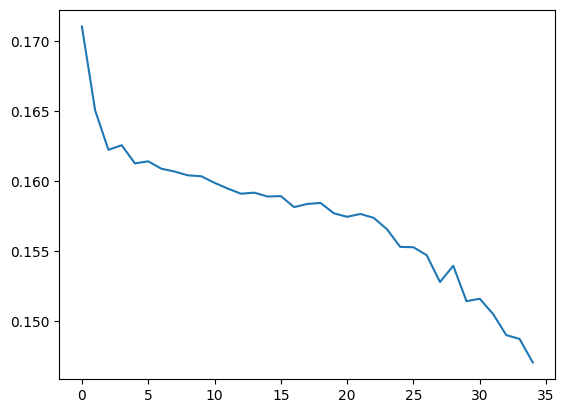

Train Loss: 0.147

Test Loss: 0.0428

['precision', 'recall', 'hit_rate', 'ndcg']
PRECISION @ 1: 0.23

RECALL @ 1: 0.0333

HIT_RATE @ 1: 0.23

NDCG @ 1: 0.23

['precision', 'recall', 'hit_rate', 'ndcg']
PRECISION @ 3: 0.1539

RECALL @ 3: 0.0777

HIT_RATE @ 3: 0.3867

NDCG @ 3: 0.1784

['precision', 'recall', 'hit_rate', 'ndcg']
PRECISION @ 5: 0.1293

RECALL @ 5: 0.1046

HIT_RATE @ 5: 0.4817

NDCG @ 5: 0.1686

['precision', 'recall', 'hit_rate', 'ndcg']
PRECISION @ 10: 0.1035

RECALL @ 10: 0.1653

HIT_RATE @ 10: 0.6633

NDCG @ 10: 0.174

['precision', 'recall', 'hit_rate', 'ndcg']
PRECISION @ 20: 0.0805

RECALL @ 20: 0.2413

HIT_RATE @ 20: 0.8067

NDCG @ 20: 0.1923

['precision', 'recall', 'hit_rate', 'ndcg']
PRECISION @ 50: 0.0521

RECALL @ 50: 0.3588

HIT_RATE @ 50: 0.9383

NDCG @ 50: 0.2253

['precision', 'recall', 'hit_rate', 'ndcg']
PRECISION @ 100: 0.0373

RECALL @ 100: 0.4767

HIT_RATE @ 100: 0.9833

NDCG @ 100: 0.2595



In [16]:
hparam_combinations = param_comb(config=MODEL_CONFIG, is_tune=TUNE)

for hparams in hparam_combinations:
    # MERGE: Combine fixed settings with current trial settings
    # This ensures 'step_size' and 'gamma' are available

    print(f"vebose: {hparams}")

    # ------------------------------------------------------------------------------
    # ------ Model Related Parameters
    # ------------------------------------------------------------------------------

    EPOCHS = hparams["epochs"]
    BATCH_SIZE = hparams["batch_size"]
    N_WORKERS = hparams["n_workers"]

    STEP_SIZE = hparams["step_size"]
    GAMMA = hparams["gamma"]

    LEARNING_RATE = hparams["learning_rate"]
    LAYERS = hparams["layers"]
    DROPOUT = hparams["dropout"]

    LOG_EVERY = hparams["log_every"]
    THRESHOLD = hparams["threshold"]

    # ------------------------------------------------------------------------------
    # ------ Train
    # ------------------------------------------------------------------------------

    ncf_model = NCFModel(
        n_users=data.n_users,
        n_items=data.n_items,
        epochs=EPOCHS,
        step_size=STEP_SIZE,
        gamma=GAMMA,
        learning_rate=LEARNING_RATE,
        log_every=LOG_EVERY,
        threshold=THRESHOLD,
        layers=LAYERS,
        dropout=DROPOUT,
        model_type=MODEL_TYPE,
    )

    all_losses_list = ncf_model.train(
        data.train_loader(batch_size=BATCH_SIZE, n_workers=N_WORKERS, shuffle=True)
    )

    # Plot Loss
    plt.figure()
    plt.plot(all_losses_list)
    plt.show()

    print("Train Loss: {}\n".format(np.round(all_losses_list[-1], 4)))

    # ------------------------------------------------------------------------------
    # ------ Evaluation (Test set)
    # ------------------------------------------------------------------------------

    test_loader = data.test_loader(
        batch_size=BATCH_SIZE, n_workers=N_WORKERS, shuffle=False
    )

    test_loss = ncf_model.evaluate(test_loader)
    print("Test Loss: {}\n".format(np.round(test_loss, 4)))

    if not TUNE:

        K = [1, 3, 5, 10, 20, 50, 100]
        metrics_to_compute = ["precision", "recall", "hit_rate", "ndcg"]

        user_pred_true = collect_user_predictions(test_loader, ncf_model.model, DEVICE)

        for k in K:

            if "rmse" in metrics_to_compute and k != K[0]:
                metrics_to_compute.remove("rmse")

            print(metrics_to_compute)

            metrics = compute_metrics(
                user_pred_true=user_pred_true,
                metrics=metrics_to_compute,
                k=k,
                threshold=THRESHOLD,
            )

            for metric in metrics_to_compute:
                if metric != "rmse":
                    print(
                        "{} @ {}: {}\n".format(
                            metric.upper(), k, np.round(metrics[metric], 4)
                        )
                    )
                else:
                    print(
                        "{}: {}\n".format(metric.upper(), np.round(metrics[metric], 4))
                    )